In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def Cnk(n, k):
    if k == 0 or k == n:
        return 1
    else:
        return Cnk(n - 1, k - 1) * n / k

In [17]:
np.random.seed(42)

In [18]:
q = 2
T = 1e-6 #T = 1 мкс (микросекунда)
f0 = 40e6  # 40 МГц (мегагерц)
dtf = 1 / T
Ns = 50
A = 1
dt = 1 / (Ns * f0)

In [19]:
t = np.arange(0, T, dt)
f = np.zeros(q)
s = np.zeros((q, len(t)))
f1 = np.zeros((q, len(t)))
f2 = np.zeros((q, len(t)))
a = np.zeros((q, len(t)))
sina = np.zeros((q, len(t)))
cosa = np.zeros((q, len(t)))

In [20]:
for i in range(1, q + 1):
    f[i - 1] = f0 + (i - 1) * dtf
    s[i - 1, :] = A * np.cos(2 * np.pi * f[i - 1] * t)
    f1[i - 1, :] = np.sqrt(2 / T) * np.cos(2 * np.pi * f[i - 1] * t)
    f2[i - 1, :] = np.sqrt(2 / T) * np.sin(2 * np.pi * f[i - 1] * t)
    a[i - 1, :] = 2 * np.pi * f[i - 1] * t
    sina[i - 1, :] = np.sin(a[i-1])
    cosa[i - 1, :] = np.cos(a[i-1])

In [21]:
E = np.linalg.norm(s[0, :]) ** 2
max_value = 0
index_max = 0
Nerrmax = 100
num_tests = 50000
SNRdb = np.arange(1, 11)
Pe = np.zeros(len(SNRdb))
Pe_teor = np.zeros(len(SNRdb))

In [22]:
for ns in range(len(SNRdb)):
    SNR = 10 ** (SNRdb[ns] / 10)
    N0 = E / SNR
    sigma = np.sqrt(N0 / 2)
    Nerr = 0
    Ntest = 0
    Pe_t = 0
    
    for l in range(1, q):
        Pe_t = Pe_t + Cnk(q - 1, l) * (-1) ** (l + 1) * 1 / (1 + l) * np.exp(-l / (l + 1) * E / N0)

    last_test = Ntest

    while Nerr < Nerrmax:
        
        i = np.random.randint(1, q+1)
        b = 2 * np.pi * np.random.rand()
        j = cosa[i-1]*np.cos(b) + sina[i-1]*np.sin(b)
        r = j + sigma * np.random.randn(len(t))

        rci = np.zeros(q)
        rsi = np.zeros(q)
        ni = np.zeros(q)

        for j in range(q):
            rci[j] = np.dot(r, f1[j, :])
            rsi[j] = np.dot(r, f2[j, :])
            ni[j] = (rci[j] ** 2) + (rsi[j] ** 2)

        index_max = np.argmax(ni)

        if index_max != (i - 1):
            Nerr = Nerr + 1
            # print(f'{index_max + 1} != {i}')
            # print(f'SNRdb = {SNRdb[ns]} | {Nerr} Nerr | {Ntest} Ntest')

        Ntest = Ntest + 1

        # if Ntest - last_test > num_tests:
        #     print(f'> {num_tests} tests')
        #     print('Pe ~= 0')
        #     break

    Pe[ns] = Nerr / Ntest
    Pe_teor[ns] = Pe_t
    # print(f'Pe {Pe[ns]}')

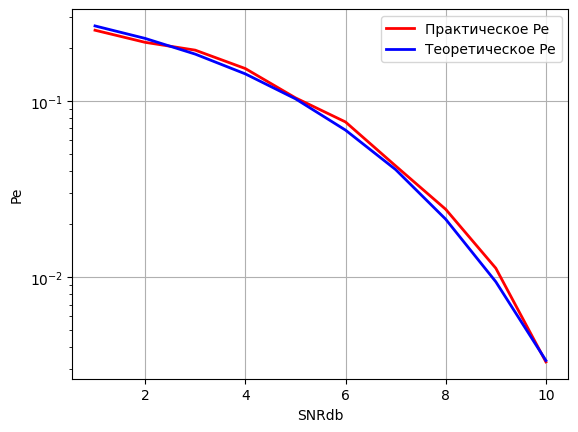

In [23]:
plt.figure(1)
plt.semilogy(SNRdb, Pe, 'r', label='Практическое Pe', linewidth=2)
plt.semilogy(SNRdb, Pe_teor, 'blue', label='Теоретическое Pe', linewidth=2)
plt.xlabel('SNRdb')
plt.ylabel('Pe')
plt.legend()
plt.grid(True)
plt.show()